In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import numpy as np
from scipy.stats import norm, foldnorm

In [3]:
df = pd.read_csv("dew-point-pitching/data.csv")
df

,PID,INNING_KEY,BATTER_IN_INNING_KEY,PITCH_NUMBER,OUT_KEY,BALLS,STRIKES,IS_RUNNER_ON_1B,IS_RUNNER_ON_2B,IS_RUNNER_ON_3B,...,HORIZONTAL_BREAK,SPIN_RATE_ABSOLUTE,RELEASE_SPEED,RELEASE_SIDE,RELEASE_HEIGHT,RELEASE_EXTENSION,HORIZONTAL_APPROACH_ANGLE,VERTICAL_APPROACH_ANGLE,PLATE_X,PLATE_Z
0,197,1,1,1,0,0,0,0,0,0,...,-12.36030,2402.459961,100.764999,-2.42717,6.08550,6.46,1.612990,-5.76003,0.197045,1.91282
1,348,1,2,1,1,0,0,0,0,0,...,-10.95030,2273.459961,100.431000,-2.52253,5.97044,6.56,0.631016,-4.60990,-0.943079,2.87744
2,1072,1,2,2,1,1,0,0,0,0,...,4.35335,2314.459961,89.848999,-2.64242,5.89410,6.71,3.330480,-6.76551,0.012025,2.16833
3,420,1,3,1,1,0,0,1,0,0,...,4.27254,2340.459961,89.810997,-2.52429,5.90717,6.55,3.804230,-6.87764,0.584736,2.11319
4,198,1,3,2,1,0,1,1,0,0,...,1.62418,2445.459961,89.014397,-2.68096,6.10905,6.37,2.385210,-5.89879,-0.634335,3.45222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9884,22663,9,4,2,2,1,0,1,0,0,...,-8.54239,2139.620117,92.623001,-2.01709,6.18892,5.81,2.164890,-4.58267,0.750023,3.40322
9885,28642,9,4,3,2,1,1,1,0,0,...,0.60670,2104.620117,88.973701,-2.22191,6.09663,5.71,3.371970,-5.39125,0.872825,3.17087
9886,22664,9,4,4,2,2,1,1,0,0,...,-10.84110,2142.620117,92.265297,-1.99639,6.21051,5.83,0.063614,-5.65863,-0.988207,2.56097
9887,22665,9,4,5,2,2,2,1,0,0,...,-13.44000,1968.619995,84.541603,-2.25819,6.13594,5.60,0.865016,-6.89677,-0.278290,2.14642


In [4]:
innings = df['INNING_KEY'].tolist()

In [17]:
in_seq = [innings[0]]
game_idx = []
last_idx = 0
for k, i in enumerate(innings[1:]):
    if i == 1 and in_seq[-1] == 9:
        game_idx.append((last_idx, k+2))
        last_idx = k+3

    if in_seq[-1] == i:
        continue
    else:
        in_seq.append(i)


In [18]:
sum([1 if i == 9 else 0 for i in in_seq])

65

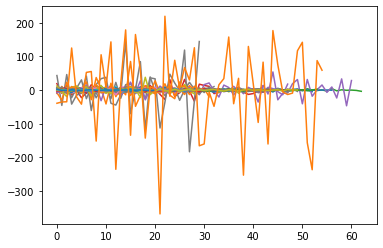

In [58]:
num_innings = []
num_pitches = []
for start, end in game_idx:
    game_df = df.iloc[start: end]
    pitchers = game_df['PITCHER_KEY'].unique()
    for pitcher in pitchers[:1]:
        pdf = game_df[game_df['PITCHER_KEY'] == pitcher]
        
        num_innings.append(max(pdf['INNING_KEY']) - min(pdf['INNING_KEY']))
        num_pitches.append(len(pdf))
        for p_type in pdf['PITCH_TYPE_TRACKED_KEY'].unique():
            specific_pitch = pdf[pdf['PITCH_TYPE_TRACKED_KEY'] == p_type]

            x = specific_pitch[['HORIZONTAL_APPROACH_ANGLE', 'HORIZONTAL_BREAK']]
            
            y = specific_pitch['PLATE_X'].to_numpy()

            x = sm.add_constant(x)
            result = sm.OLS(y,x).fit()

            diff = y - np.array(result.predict(x))
            try:
                vol = (diff[:-1] - diff[1:])/diff[:1]
                # plt.plot(vol)
                if len(vol) < 20:
                    continue
            except Exception as e:
                pass
            # print(pitcher, p_type, specific_pitch['PLATE_X'])
            plt.plot(vol)

82.67796610169492


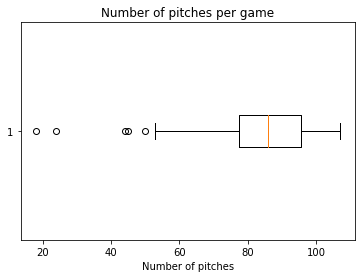

In [59]:
plt.boxplot(num_pitches, vert=False)
plt.title("Number of pitches per game")
plt.xlabel("Number of pitches")
print(np.mean(num_pitches))